In [ ]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
import numpy as np
import os
import slsim
from slsim.Lenses.lens_pop import LensPop
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
from slsim.Sources.SourceCatalogues.QuasarCatalog.quasar_pop import QuasarRate
import matplotlib.pyplot as plt
from slsim.ImageSimulation.image_simulation import (
    point_source_coordinate_properties,
    lens_image_series,
    rgb_image_from_image_list,
)
from slsim.Plots.plot_functions import create_image_montage_from_image_list

from taufit import fit_drw
from astropy import units as u
import corner

# roman filters
import speclite
from slsim.Pipelines import roman_speclite

# from slsim.ImageSimulation.roman_image_simulation import simulate_roman_image
from slsim.ImageSimulation.image_simulation import simulate_image

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configure LSST, Euclid, and Roman Filters

In [4]:
# Import default Euclid, LSST and Roman Space Telescope configuration
path = os.path.dirname(slsim.__file__)
module_path, _ = os.path.split(path)
skypy_config = os.path.join(module_path, "data/SkyPy/euclid-roman-lsst-like.yml")

# generate Roman filters
roman_speclite.configure_roman_filters()

# import filter bands and make them recognizable in speclite
# roman_filters = roman_speclite.filter_names()
# filters are ['Roman-F062', 'Roman-F087', 'Roman-F106', 'Roman-F129', 'Roman-F158', 'Roman-F184', 'Roman-F146', 'Roman-F213']


# speclite.filters.load_filters(
#     roman_filters[0],
#     roman_filters[1],
#     roman_filters[2],
#     roman_filters[3],
#     roman_filters[4],
#     roman_filters[5],
#     roman_filters[6],
#     roman_filters[7],
# )

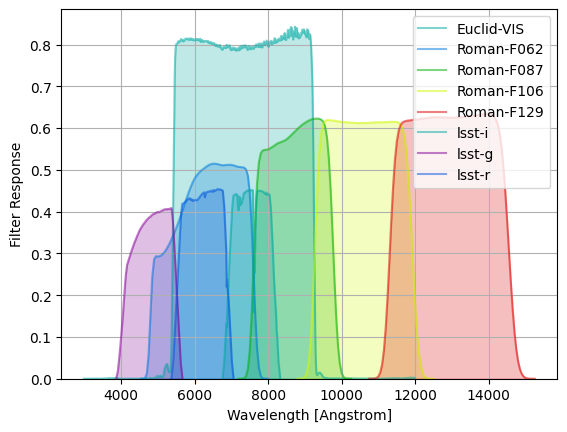

In [5]:
filters = speclite.filters.load_filters(
    "Euclid-VIS",
    "Roman-F062",
    "Roman-F087",
    "Roman-F106",
    "Roman-F129",
    "lsst2016-i",
    "lsst2016-g",
    "lsst2016-r",
)
speclite.filters.plot_filters(filters)

## Lensed quasar population

This notebook shows how to simulate lensed quasar population with variability. For LSST, Euclid and Roman.

In [6]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define a sky area
galaxy_sky_area = Quantity(value=1, unit="deg2")
quasar_sky_area = Quantity(value=5, unit="deg2")
full_sky_area = Quantity(value=1000, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "i", "band_max": 26, "z_min": 0.001, "z_max": 5.0}

# NOTE: By default only the i-band information is available for the quasar sources generated using the QuasarRate class.
# So for kwargs_source_cut, we need provide the i-band cuts.
# If you have any other band information available for a population of quasars, you can use that band instead,
# but then you'd use your own table of quasar properties instead of generating it using the QuasarRate class.

In [7]:
# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=skypy_config, sky_area=galaxy_sky_area, filters=None, cosmo=cosmo
)

In [8]:
# Initiate deflector popiulation class
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=galaxy_sky_area,
)
# lens_galaxies = deflectors.EllipticalLensGalaxies(
#     galaxy_list=galaxy_simulation_pipeline.red_galaxies,
#     kwargs_cut=kwargs_deflector_cut,
#     kwargs_mass2light={},
#     cosmo=cosmo,
#     sky_area=galaxy_sky_area,
# )

/Users/paras/Projects/repos/self/slsim/slsim/Deflectors/DeflectorPopulation/all_lens_galaxies.py:56: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/Users/paras/Projects/repos/self/slsim/slsim/Deflectors/DeflectorPopulation/all_lens_galaxies.py:59: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


In [9]:
# Initiate QuasarRate class to generate quasar sample.
quasar_class = QuasarRate(
    skypy_config=skypy_config,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    noise=True,
    redshifts=np.linspace(0.001, 5.01, 100),  # these redshifts are provided
    # to match general slsim redshift range in skypy pipeline.
)
quasar_source = quasar_class.quasar_sample(m_min=15, m_max=30, host_galaxy=True)

Matching quasars with host galaxies:   4%|▍         | 2287/52838 [00:00<00:08, 5762.97it/s]/Users/paras/Projects/repos/self/slsim/slsim/Sources/SourceCatalogues/QuasarCatalog/quasar_host_match.py:123: RuntimeWarning: divide by zero encountered in log10
  M_bol = M_bol_sun - 2.5 * np.log10(L_bol)  # L_sun
Matching quasars with host galaxies: 100%|██████████| 52838/52838 [00:08<00:00, 5904.60it/s]


In [10]:
# Prepare dictionary of agn variability kwargs
variable_agn_kwarg_dict = {
    "length_of_light_curve": 2500,
    "time_resolution": 1,
    "log_breakpoint_frequency": 1 / 20,
    "low_frequency_slope": 1,
    "high_frequency_slope": 3,
    "standard_deviation": 0.9,
}

kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {
        "agn_lightcurve",
        "i",
        "r",
        "g",
        "F184",
        "F146",
        "F129",
        "F106",
        "F062",
        "VIS",
        "Y",
        "H",
        "J",
    },
    "agn_driving_variability_model": "bending_power_law",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(-5000, 5000, 10000),
    "corona_height": 10,
    "r_resolution": 500,
}
# Initiate source population class.
# source_quasar = sources.PointSources(
#     quasar_source,
#     cosmo=cosmo,
#     sky_area=quasar_sky_area,
#     kwargs_cut=kwargs_source_cut,
#     point_source_type="quasar",
#     point_source_kwargs=kwargs_quasar,
# )

# Point source quasar population with host galaxy
source_quasar = sources.PointPlusExtendedSources(
    point_plus_extended_sources_list=quasar_source,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    list_type="astropy_table",
    catalog_type="skypy",
    point_source_type="quasar",
    extended_source_type="single_sersic",
    point_source_kwargs=kwargs_quasar,
)

In [11]:
# Initiate LensPop class to generate lensed quasar pop.
quasar_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

## Draw lenses

In [12]:
kwargs_lens_cuts = {
    "min_image_separation": 1,  # arcsec
    # # # "max_image_separation": 10,  # arcsec
    # "mag_arc_limit": {"i": 26},
    # "second_brightest_image_cut": {"i": 24},
}
# drawing population
quasar_lens_population = quasar_lens_pop.draw_population(
    speed_factor=1000, kwargs_lens_cuts=kwargs_lens_cuts
)

## Show Image of Lenses for Euclid LSST and Roman

### Find Doubles and Quads

In [13]:
quad_indices = []
double_indices = []
for i, lens in enumerate(quasar_lens_population):
    if lens.image_number[0] == 2:
        double_indices.append(i)
    elif lens.image_number[0] == 4:
        quad_indices.append(i)

print("double_indices: ", double_indices)
print("quad_indices: ", quad_indices)

double_indices:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222

### Select a Quad and Visualize

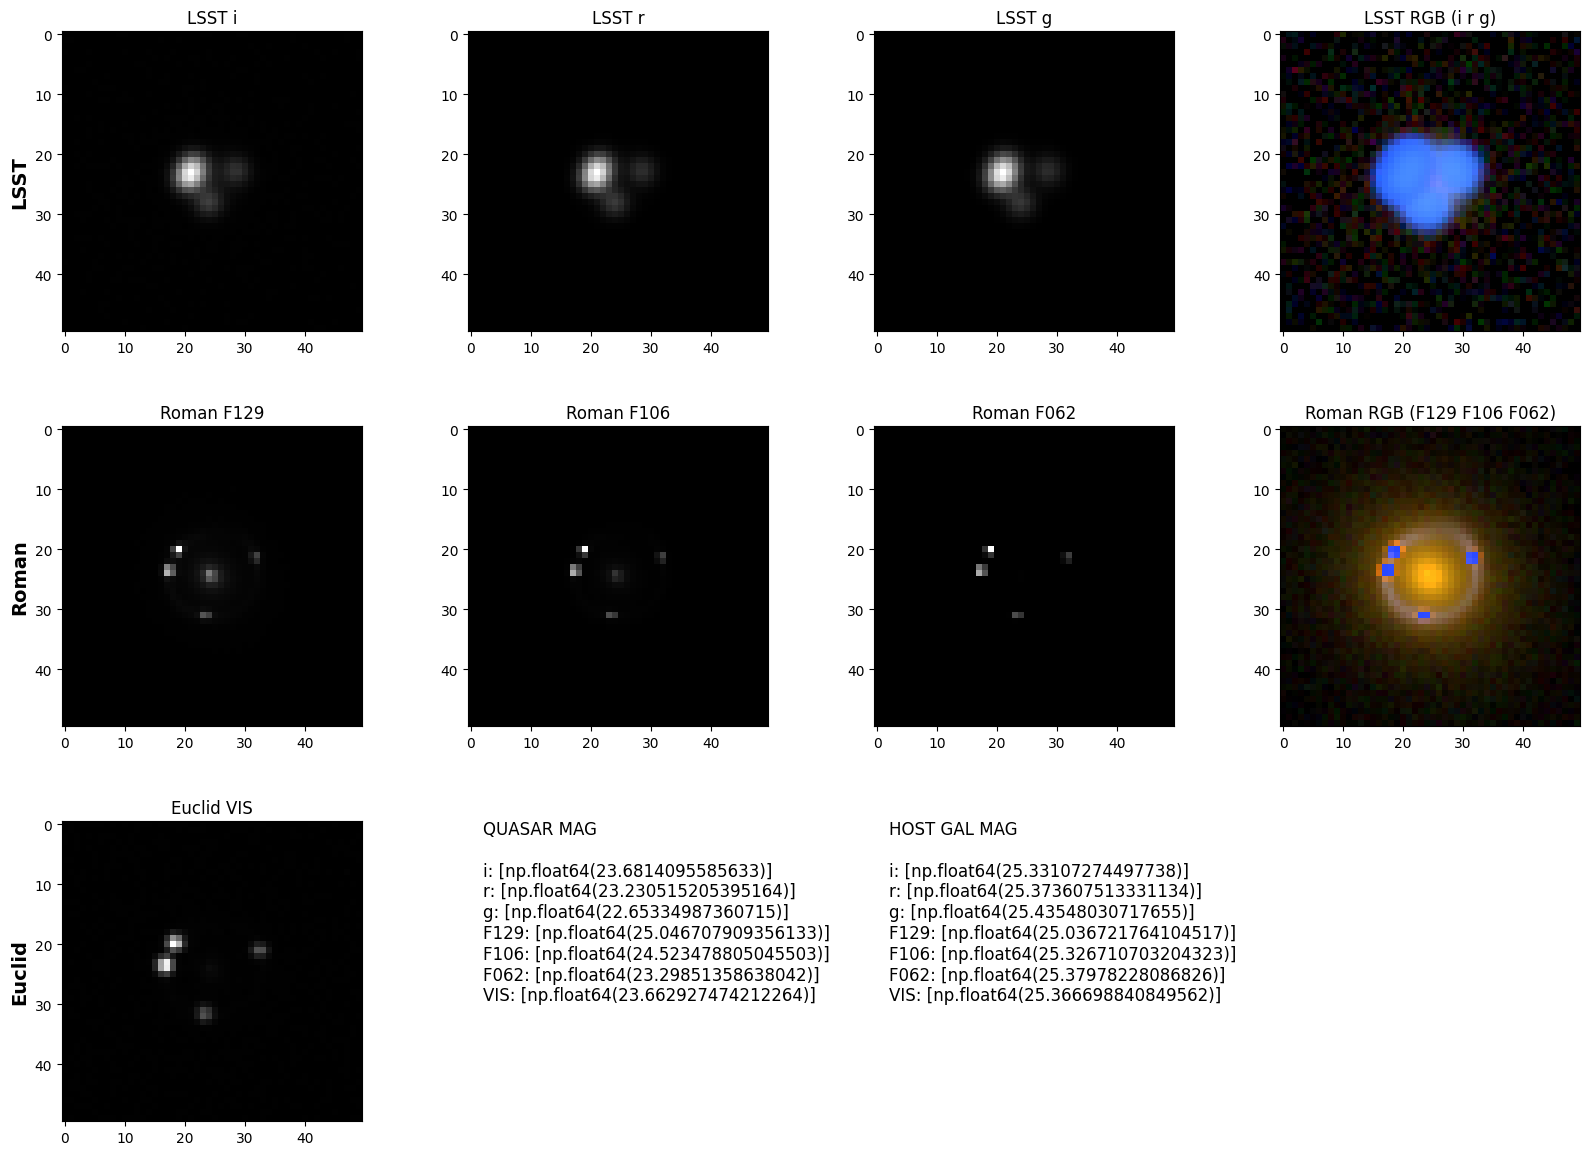

In [17]:
selected_lens = quasar_lens_population[42]

with_deflector = True
with_point_source = True
with_extended_source = True

# --- LSST Simulation ---
lsst_band_images = {}
lsst_bands = ["i", "r", "g"]
for band in lsst_bands:
    lsst_band_images[band] = simulate_image(
        lens_class=selected_lens,
        band=band,
        observatory="LSST",
        num_pix=50,
        add_noise=True,
        with_source=with_extended_source,
        with_deflector=with_deflector,
        with_point_source=with_point_source,
    )

rgb_LSST = rgb_image_from_image_list(
    image_list=[lsst_band_images["i"], lsst_band_images["r"], lsst_band_images["g"]],
    stretch=1.0,
)

# --- Roman Simulation ---
roman_band_images = {}
for band in ["F184", "F129", "F106", "F062"]:
    # This function has some issues so we will use the simulate_image function for now
    # roman_band_images[band] = simulate_roman_image(
    #     lens_class=selected_lens,
    #     band=band,
    #     num_pix=50,
    #     add_noise=True,
    #     observatory="Roman",
    #     with_deflector=with_deflector,
    #     with_source=with_extended_source,
    #     with_point_source=with_point_source,
    # )
    roman_band_images[band] = simulate_image(
        lens_class=selected_lens,
        band=band,
        observatory="Roman",
        num_pix=50,
        add_noise=True,
        with_source=with_extended_source,
        with_deflector=with_deflector,
        with_point_source=with_point_source,
    )

rgb_roman = rgb_image_from_image_list(
    image_list=[
        roman_band_images["F129"],
        roman_band_images["F106"],
        roman_band_images["F062"],
    ],
    stretch=0.5,
)

# --- Euclid Simulation ---
euclid_band_images = {}
for band in ["VIS"]:
    euclid_band_images[band] = simulate_image(
        lens_class=selected_lens,
        band=band,
        observatory="Euclid",
        num_pix=50,
        add_noise=True,
        with_source=with_extended_source,
        with_deflector=with_deflector,
        with_point_source=with_point_source,
    )

# Plot the images
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

# Row 0: LSST
axes[0, 0].imshow(lsst_band_images["i"], cmap="gray")
axes[0, 0].set_title("LSST i")
axes[0, 1].imshow(lsst_band_images["r"], cmap="gray")
axes[0, 1].set_title("LSST r")
axes[0, 2].imshow(lsst_band_images["g"], cmap="gray")
axes[0, 2].set_title("LSST g")
axes[0, 3].imshow(rgb_LSST)
axes[0, 3].set_title("LSST RGB (i r g)")

# Row 1: Roman
axes[1, 0].imshow(roman_band_images["F129"], cmap="gray")
axes[1, 0].set_title("Roman F129")
axes[1, 1].imshow(roman_band_images["F106"], cmap="gray")
axes[1, 1].set_title("Roman F106")
axes[1, 2].imshow(roman_band_images["F062"], cmap="gray")
axes[1, 2].set_title("Roman F062")
axes[1, 3].imshow(rgb_roman)
axes[1, 3].set_title("Roman RGB (F129 F106 F062)")

# Row 2: Euclid
# Euclid only has 1 image, so we plot it in the first column
axes[2, 0].imshow(euclid_band_images["VIS"], cmap="gray")
axes[2, 0].set_title("Euclid VIS")

# Turn off the empty axes in the Euclid row (columns 1, 2, 3)
for j in range(1, 4):
    axes[2, j].axis("off")

axes[0, 0].set_ylabel("LSST", fontsize=14, fontweight="bold")
axes[1, 0].set_ylabel("Roman", fontsize=14, fontweight="bold")
axes[2, 0].set_ylabel("Euclid", fontsize=14, fontweight="bold")

# in the empty axes, add text to show quasar and host gal mag in all bands
quasar_mag_string = "QUASAR MAG\n\n"
host_mag_string = "HOST GAL MAG\n\n"
for band in ["i", "r", "g", "F129", "F106", "F062", "VIS"]:
    quasar_mag_string += f"{band}: {selected_lens.point_source_magnitude(band=band)}\n"
    host_mag_string += f"{band}: {selected_lens.extended_source_magnitude(band=band)}\n"
axes[2, 1].text(
    0.05,
    0.95,
    quasar_mag_string,
    transform=axes[2, 1].transAxes,
    fontsize=12,
    verticalalignment="top",
)
axes[2, 2].text(
    0.05,
    0.95,
    host_mag_string,
    transform=axes[2, 2].transAxes,
    fontsize=12,
    verticalalignment="top",
)

plt.tight_layout()
plt.show()

### Plot Montage of Lensed Quasar Populations for Euclid, Roman and LSST

Simulating images for 49 lenses...
Processed 5/49 lenses
Processed 10/49 lenses
Processed 15/49 lenses
Processed 20/49 lenses
Processed 25/49 lenses
Processed 30/49 lenses
Processed 35/49 lenses
Processed 40/49 lenses
Processed 45/49 lenses


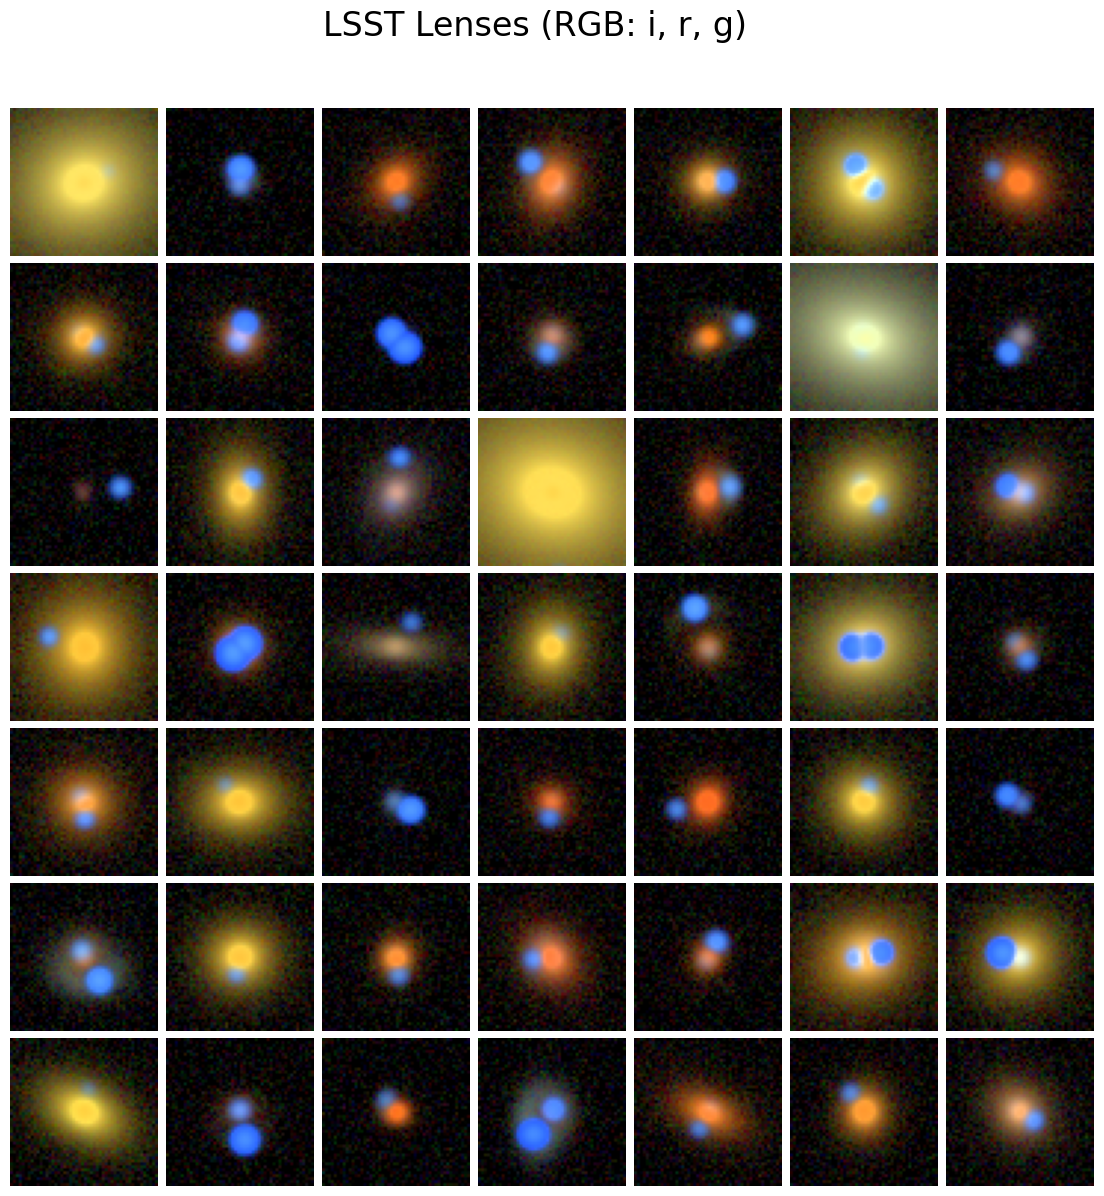

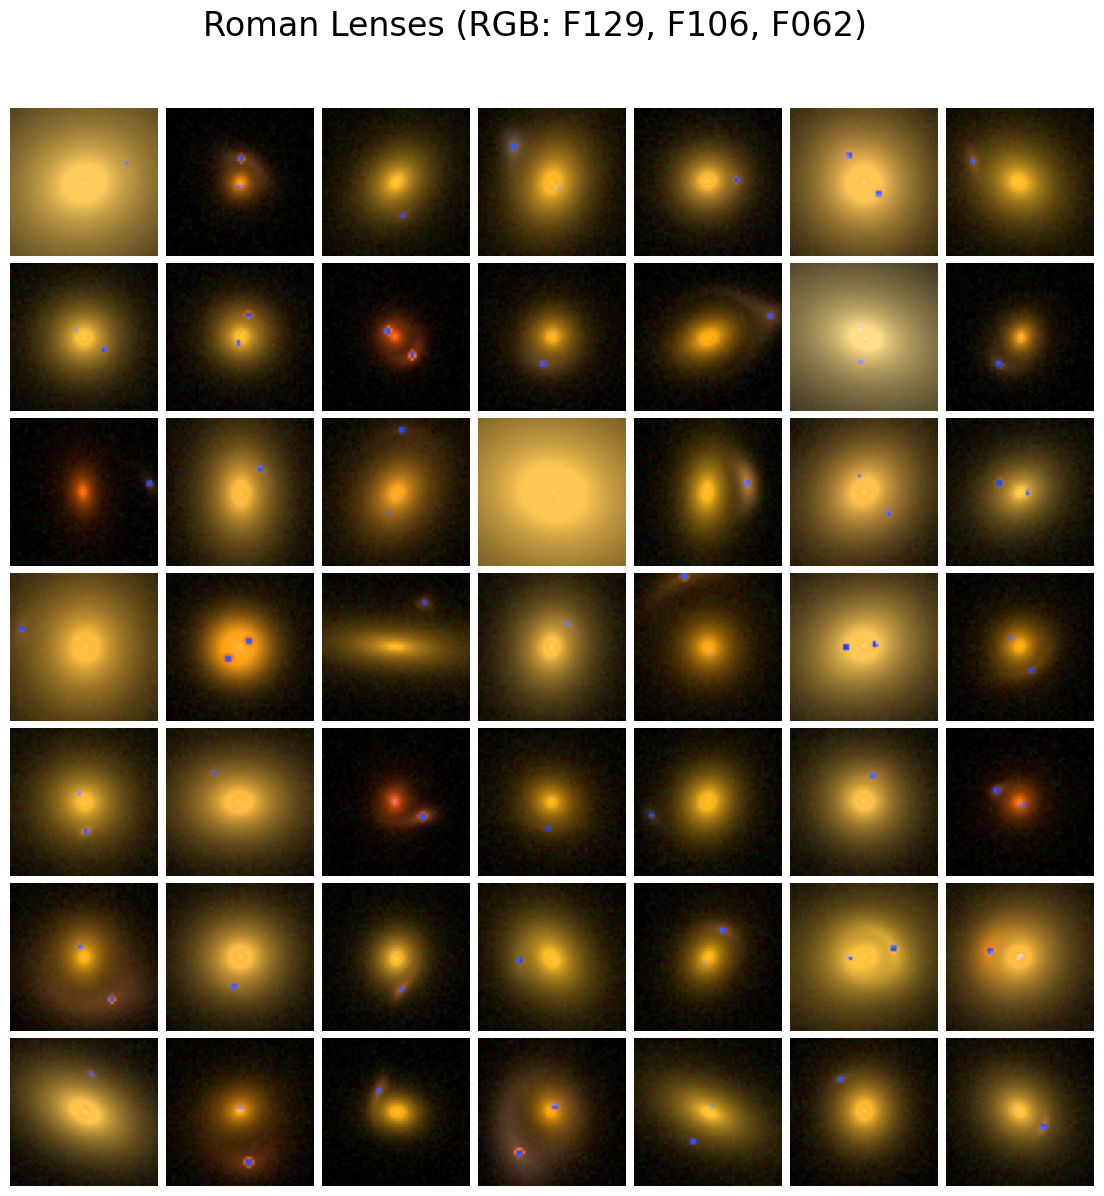

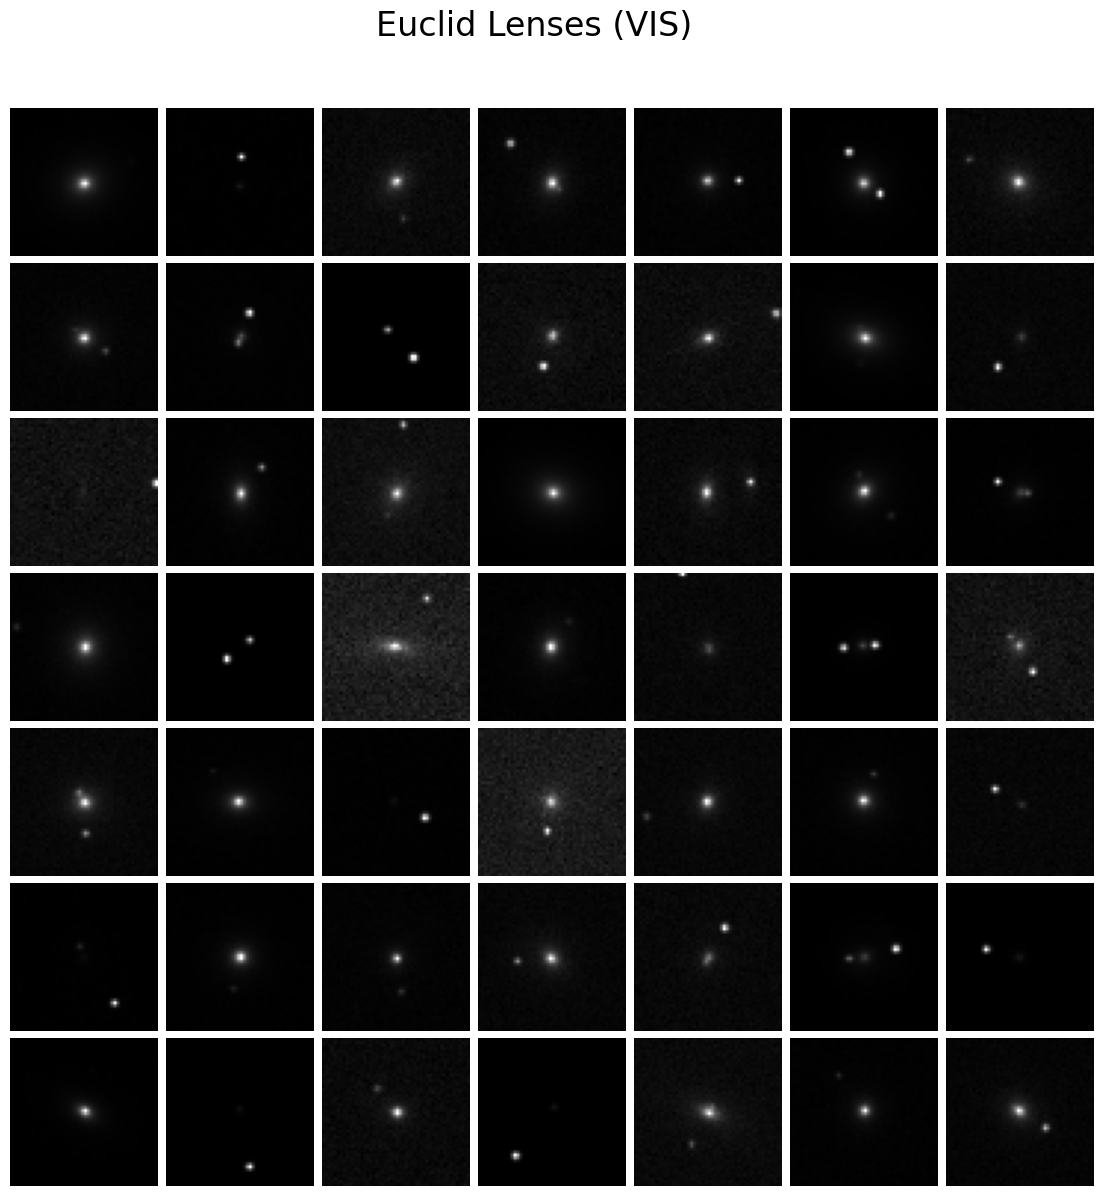

In [169]:
# Select random lenses from lens population
num_lenses = 49
indices = np.random.choice(len(quasar_lens_population), size=num_lenses, replace=False)
selected_lenses = [quasar_lens_population[i] for i in indices]

# Simulation settings
num_pix = 50
with_deflector = True
with_point_source = True
with_extended_source = True

# Lists to store the final images for the montage
lsst_rgb_images = []
roman_rgb_images = []
euclid_vis_images = []

print(f"Simulating images for {num_lenses} lenses...")

for i, lens in enumerate(selected_lenses):
    # --- LSST (RGB: i, r, g) ---
    lsst_bands = ["i", "r", "g"]
    lsst_images = []
    for band in lsst_bands:
        img = simulate_image(
            lens_class=lens,
            band=band,
            observatory="LSST",
            num_pix=num_pix,
            add_noise=True,
            with_source=with_extended_source,
            with_deflector=with_deflector,
            with_point_source=with_point_source,
        )
        lsst_images.append(img)

    # Create RGB for LSST
    rgb_lsst = rgb_image_from_image_list(image_list=lsst_images, stretch=1.0)
    lsst_rgb_images.append(rgb_lsst)

    # --- Roman (RGB: F129, F106, F062) ---
    roman_bands = ["F129", "F106", "F062"]
    roman_images = []
    for band in roman_bands:
        img = simulate_image(
            lens_class=lens,
            band=band,
            observatory="Roman",
            num_pix=num_pix,
            add_noise=True,
            with_source=with_extended_source,
            with_deflector=with_deflector,
            with_point_source=with_point_source,
        )
        roman_images.append(img)

    # Create RGB for Roman
    rgb_roman = rgb_image_from_image_list(image_list=roman_images, stretch=0.5)
    roman_rgb_images.append(rgb_roman)

    # --- Euclid (VIS) ---
    vis_img = simulate_image(
        lens_class=lens,
        band="VIS",
        observatory="Euclid",
        num_pix=num_pix,
        add_noise=True,
        with_source=with_extended_source,
        with_deflector=with_deflector,
        with_point_source=with_point_source,
    )
    euclid_vis_images.append(vis_img)

    # Optional: Progress indicator
    if (i + 1) % 5 == 0:
        print(f"Processed {i + 1}/{num_lenses} lenses")


# --- Plotting Function ---
def plot_montage(image_list, title, cmap=None):
    fig, axes = plt.subplots(7, 7, figsize=(14, 14))
    fig.suptitle(title, fontsize=24, y=0.95)

    for i, ax in enumerate(axes.flat):
        if i < len(image_list):
            # For RGB images (LSST/Roman), cmap is ignored by imshow usually
            # For single band (Euclid), we use 'gray'
            if cmap:
                ax.imshow(image_list[i], cmap=cmap, origin="lower")
            else:
                ax.imshow(image_list[i], origin="lower")
            ax.axis("off")
        else:
            ax.axis("off")

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


# 3. Generate the 3 Plots
plot_montage(lsst_rgb_images, "LSST Lenses (RGB: i, r, g)")
plot_montage(roman_rgb_images, "Roman Lenses (RGB: F129, F106, F062)")
plot_montage(euclid_vis_images, "Euclid Lenses (VIS)", cmap="gray")

## Select a lens to visualize its lightcurves

In [229]:
# Select a random lens
kwargs_lens_cut = {"min_image_separation": 2, "max_image_separation": 10}
lens_class = quasar_lens_pop.select_lens_at_random(**kwargs_lens_cut)

# lens_class = quasar_lens_population[13]

In [230]:
# Get a point source coordinate so that you can plot these image center in the plot.
pix_coord = point_source_coordinate_properties(
    lens_class,
    band="i",
    mag_zero_point=35,
    delta_pix=0.2,
    num_pix=64,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
)["image_pix"]

print(pix_coord)

/Users/paras/miniconda3/lib/python3.13/site-packages/astropy/units/quantity.py:653: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/paras/miniconda3/lib/python3.13/site-packages/astropy/units/quantity.py:653: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/paras/miniconda3/lib/python3.13/site-packages/astropy/units/quantity.py:653: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/paras/miniconda3/lib/python3.13/site-packages/astropy/units/quantity.py:653: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[array([30.82601374, 22.98666461]), array([30.08106453, 37.12219725])]


## See the light curve of a selected quasar

In [238]:
time = np.linspace(0, 5000, 500)
image_observation_times = lens_class.image_observer_times(time)

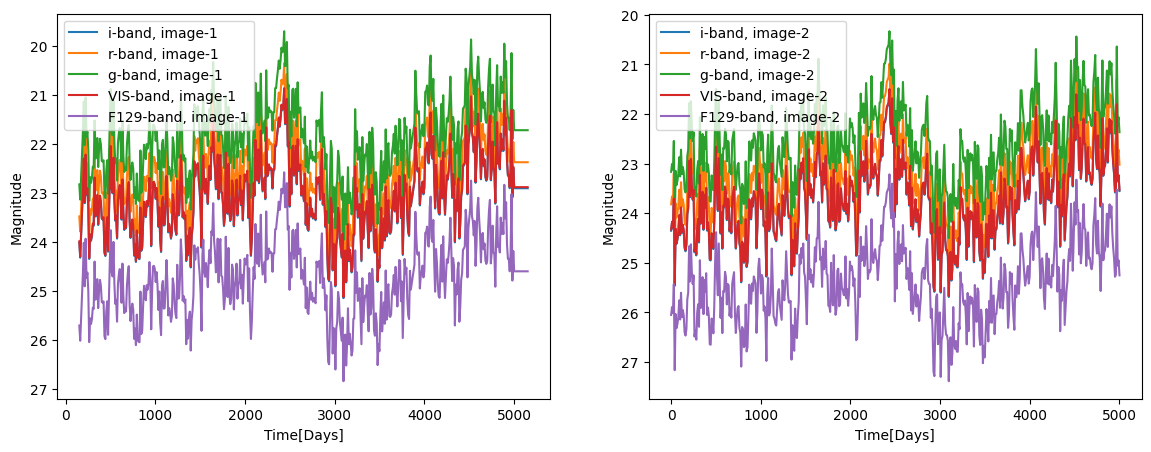

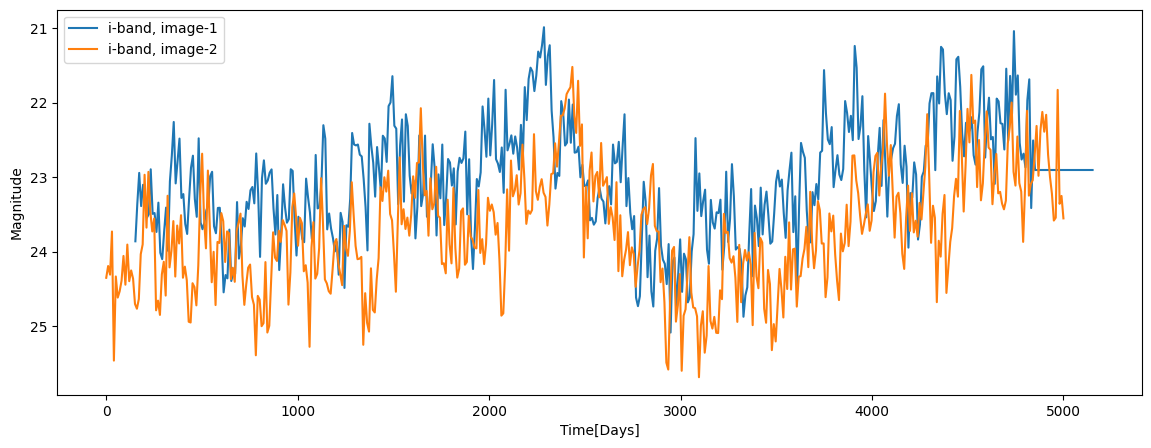

In [239]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for band in ["i", "r", "g", "VIS", "F129"]:
    ax1.plot(
        image_observation_times[0],
        lens_class.point_source_magnitude(band=band, lensed=True, time=time)[0][0],
        label=f"{band}-band, image-1",
    )
# ax1.gca().invert_yaxis()
ax1.set_ylabel("Magnitude")
ax1.set_xlabel("Time" "[Days]")
# ax1.set_xlim(0, 500)
# ax1.set_ylim(19.5, 21.25)
for band in ["i", "r", "g", "VIS", "F129"]:
    ax2.plot(
        image_observation_times[1],
        lens_class.point_source_magnitude(band=band, lensed=True, time=time)[0][1],
        label=f"{band}-band, image-2",
    )
# ax1.gca().invert_yaxis()
ax2.set_ylabel("Magnitude")
ax2.set_xlabel("Time" "[Days]")
# ax2.set_xlim(0, 250)
# ax2.set_ylim(None, 25)
ax2.invert_yaxis()
ax1.invert_yaxis()
ax1.legend()
ax2.legend()

# now plot the i-band light curves for all images
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
for i in range(lens_class.image_number[0]):
    ax.plot(
        image_observation_times[i],
        lens_class.point_source_magnitude(
            band="i", lensed=True, time=image_observation_times[i]
        )[0][i],
        label=f"i-band, image-{i+1}",
    )
ax.invert_yaxis()
ax.set_ylabel("Magnitude")
ax.set_xlabel("Time" "[Days]")
ax.legend()

## Simulate Variable Image in LSST Bands

### Set observation time and image configuration

In [ ]:
time = np.linspace(0, 250, 10)
# time = sorted(np.random.uniform(-20, 100, 10))
# time = np.array([0, 50, 70, 120])
repeats = len(time)
# load your psf kernel and transform matrix. If you have your own psf, please provide
# it here.
path = "../../tests/TestData/psf_kernels_for_deflector.npy"
psf_kernel = 1 * np.load(path)
psf_kernel[psf_kernel < 0] = 0
transform_matrix = np.array([[0.2, 0], [0, 0.2]])

# let's set up psf kernel for each exposure. Here we have taken the same psf that we
# extracted above. However, each exposure can have different psf kernel and user should
# provide corresponding psf kernel to each exposure.
psf_kernel_list = [psf_kernel]
transform_matrix_list = [transform_matrix]
psf_kernels_all = psf_kernel_list * repeats
# psf_kernels_all = np.array([dp0["psf_kernel"][:10]])[0]

# let's set pixel to angle transform matrix. Here we have taken the same matrix for
# each exposure but user should provide corresponding transform matrix to each exposure.
transform_matrix_all = transform_matrix_list * repeats

# provide magnitude zero point for each exposures. Here we have taken the same magnitude
#  zero point for each exposure but user should provide the corresponding magnitude
# zero point for each exposure.
mag_list = [31.0]
mag_zero_points_all = mag_list * repeats
# mag_zero_points_all = np.array([dp0["zero_point"][:10]])[0]

expo_list = [30]
exposure_time_all = expo_list * repeats

### Visualize variable images

/Users/paras/miniconda3/lib/python3.13/site-packages/astropy/visualization/lupton_rgb.py:645: RuntimeWarning: invalid value encountered in divide
  fInorm = np.where(Int <= 0, 0, np.true_divide(fI, Int))


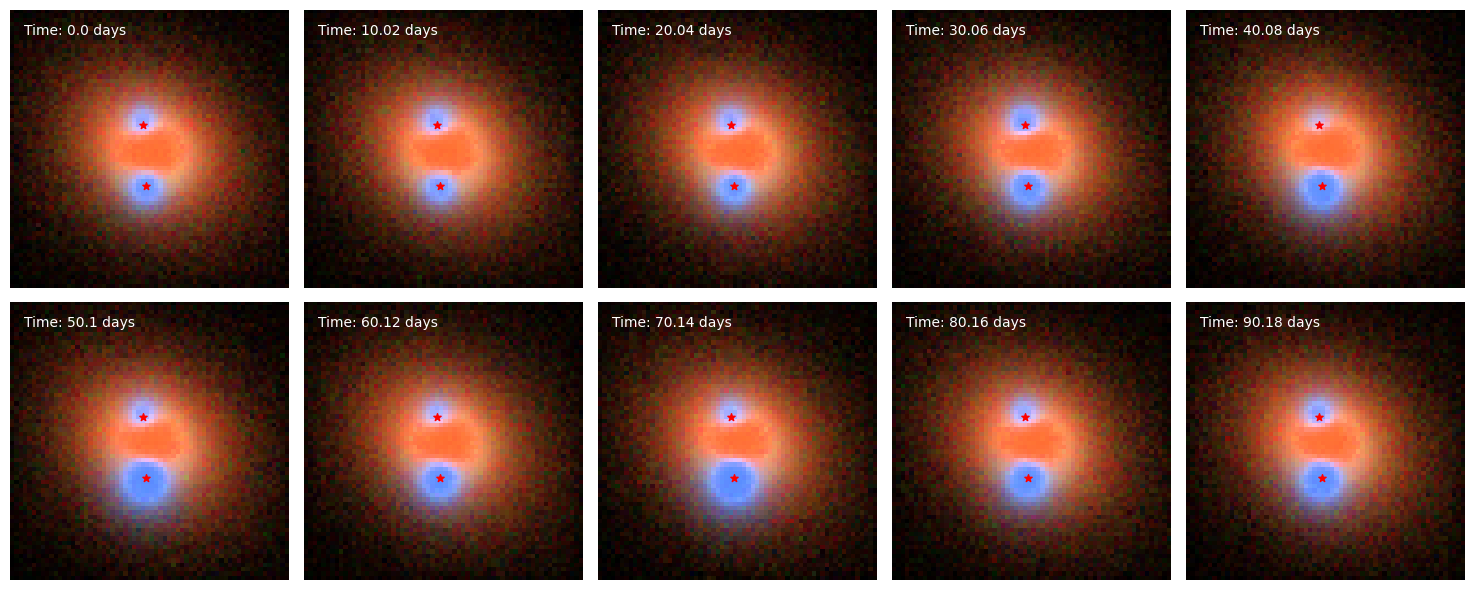

In [240]:
# Simulate a lens image
image_lens_series_i = lens_image_series(
    lens_class=lens_class,
    band="i",
    mag_zero_point=mag_zero_points_all,
    num_pix=64,
    psf_kernel=psf_kernels_all,
    transform_pix2angle=transform_matrix_all,
    exposure_time=exposure_time_all,
    t_obs=time,
    with_deflector=True,
    with_source=True,
)
image_lens_series_g = lens_image_series(
    lens_class=lens_class,
    band="g",
    mag_zero_point=mag_zero_points_all,
    num_pix=64,
    psf_kernel=psf_kernels_all,
    transform_pix2angle=transform_matrix_all,
    exposure_time=exposure_time_all,
    t_obs=time,
    with_deflector=True,
    with_source=True,
)
image_lens_series_r = lens_image_series(
    lens_class=lens_class,
    band="r",
    mag_zero_point=mag_zero_points_all,
    num_pix=64,
    psf_kernel=psf_kernels_all,
    transform_pix2angle=transform_matrix_all,
    exposure_time=exposure_time_all,
    t_obs=time,
    with_deflector=True,
    with_source=True,
)

rgb_image_list = []
for i in range(len(image_lens_series_i)):
    rgb_image_list.append(
        rgb_image_from_image_list(
            image_list=[
                image_lens_series_i[i],
                image_lens_series_r[i],
                image_lens_series_g[i],
            ],
            stretch=1.0,
        )
    )

plot_montage = create_image_montage_from_image_list(
    num_rows=2, num_cols=5, images=rgb_image_list, time=time, image_center=pix_coord
)

## EXTRA: Lensed Quasar population with variability parameters drawn from realistic distribution (MacLeod et al. 2010)

In [ ]:
#############################################################################
# Distributions from MacLeod+2010 for Quasar AGN variability parameters
# means and covariances for the log(BH_mass/Msun), M_i, log(SFi_inf/mag), log(tau/days), zsrc
MACLEOD2010_MEANS = np.array(
    [8.53308079, -23.48721021, -0.51665998, 2.28708691, 2.11640976]
)
MACLEOD2010_COV = np.array(
    [
        [0.27862905, -0.29501766, 0.00675703, 0.04606804, -0.00665875],
        [-0.29501766, 2.06855169, 0.19690851, 0.0244139, -0.29913764],
        [0.00675703, 0.19690851, 0.02785685, 0.01083628, -0.02216221],
        [0.04606804, 0.0244139, 0.01083628, 0.05636087, -0.02716507],
        [-0.00665875, -0.29913764, -0.02216221, -0.02716507, 0.3077278],
    ]
)
#############################################################################


# Prepare dictionary of agn variability kwargs
# Note: the means array and covariance matrix should be defined in following order and units:
# log(BH_mass/Msun), M_i, log(SFi_inf/mag), log(tau/days), zsrc
variable_agn_kwarg_dict = {
    "multivariate_gaussian_means": MACLEOD2010_MEANS,
    "multivariate_gaussian_covs": MACLEOD2010_COV,
    "known_band": "lsst2016-i",
}

### Also note that even if you provide variable_agn_kwarg_dict = {},
### then by default MACLEOD 2010 values are used internally
### But the above case is shown to make user aware of the flexibility
### so the user can provide their own distributions.

kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "i", "r", "g"},
    "agn_driving_variability_model": "bending_power_law_from_distribution",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, 1000, 500),
    "corona_height": 10,
    "r_resolution": 500,
}

# Initiate source population class.
source_quasar = sources.PointSources(
    quasar_source,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    point_source_type="quasar",
    point_source_kwargs=kwargs_quasar,
)

# Initiate LensPop class to generate lensed quasar pop.
quasar_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

## Draw lenses
kwargs_lens_cuts = {}
# drawing population
quasar_lens_population = quasar_lens_pop.draw_population(
    speed_factor=1000, kwargs_lens_cuts=kwargs_lens_cuts
)

In [62]:
# select two random lenses and see if quasars variability parameters are different or not?
kwargs_lens_cut = {"min_image_separation": 2, "max_image_separation": 10}

for i in range(2):
    lens_class = quasar_lens_pop.select_lens_at_random(**kwargs_lens_cut)

    # run point source magnitude function to get variability parameters assigned
    _ = lens_class.point_source_magnitude(
        band="i", lensed=True, time=np.linspace(0, 10, 1000)
    )
    print("\n")

    # print the variability parameters
    print(f" ========= LENS {i+1} ========= ")
    print(
        "Variability Model: ",
        lens_class.source(0)._source.agn_class.agn_driving_variability_model,
    )
    print(
        "Variability Parameters: ",
        lens_class.source(0)._source.agn_class.agn_driving_kwargs_variability,
    )

/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)




 ========= LENS 1 ========= 
Variability Model:  bending_power_law
Variability Parameters:  {'length_of_light_curve': np.float64(1000.0), 'time_resolution': 1, 'log_breakpoint_frequency': np.float64(-3.1527593721767255), 'low_frequency_slope': 0, 'high_frequency_slope': 2, 'standard_deviation': np.float64(0.2834336072215139)}


 ========= LENS 2 ========= 
Variability Model:  bending_power_law
Variability Parameters:  {'length_of_light_curve': np.float64(1000.0), 'time_resolution': 1, 'log_breakpoint_frequency': np.float64(-2.5937144984594274), 'low_frequency_slope': 0, 'high_frequency_slope': 2, 'standard_deviation': np.float64(0.3699320314054105)}


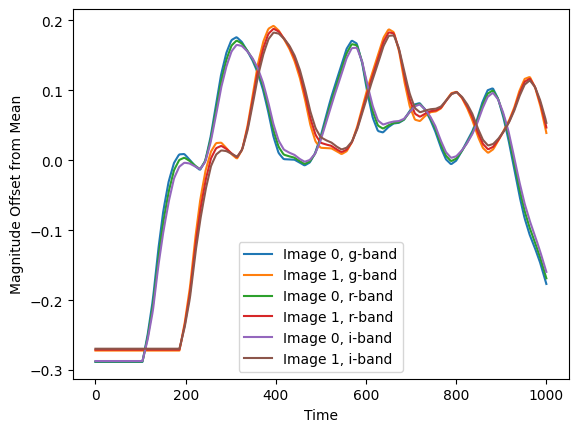

In [71]:
# Verify that the SF and Tau are different for different bands

lens_class = quasar_lens_pop.select_lens_at_random(**kwargs_lens_cut)

snapshot_times = np.linspace(0, 1000, 1000)
ps_mags = {}
ps_mags_err = {}
for band in ["g", "r", "i"]:
    ps_mags[band] = lens_class.point_source_magnitude(
        band=band, lensed=True, time=snapshot_times
    )[0]
    ps_mags_err[band] = ps_mags[band] * 0.01

for band in ["g", "r", "i"]:
    for image in range(lens_class.image_number[0]):
        plt.plot(
            snapshot_times,
            # ps_mags[band][image],
            ps_mags[band][image] - np.mean(ps_mags[band][image]),
            label=f"Image {image}, {band}-band",
        )

plt.xlabel("Time")
plt.ylabel("Magnitude Offset from Mean")
plt.legend()
plt.show()

In [64]:
for band in ["i", "r", "g"]:
    gp, samples, _ = fit_drw(
        snapshot_times * u.day,
        ps_mags[band][0] * u.mag,
        ps_mags_err[band][0] * u.mag,
        plot=False,
        verbose=False,
    )
    log_tau_drw_recovered = np.log10(1 / np.exp(np.median(samples[:, 1])))
    log_sf_drw_recovered = np.log10(np.sqrt(np.exp(np.median(samples[:, 0])) / 2))
    print(
        "Band: ",
        band,
        ";  log(tau): ",
        log_tau_drw_recovered,
        ";  log(SF): ",
        log_sf_drw_recovered,
    )

/home/paras/.venv/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Band:  i ;  log(tau):  3.039322959117967 ;  log(SF):  -1.2730382625527472
Band:  r ;  log(tau):  3.0553410131470455 ;  log(SF):  -1.2659917486101555
Band:  g ;  log(tau):  3.0306086893142914 ;  log(SF):  -1.2733674719748382


We find very slight difference in SF and Tau across the optical bands for some of the selected lenses! But for most, the difference is miniscule.

In [65]:
# for all the lenses in the quasar_lens_population, generate lightcurves
# then get SF and Tau for each quasar source.

SFs = []
Taus = []
for lens_class in quasar_lens_population:

    # run point source magnitude function to get variability parameters assigned
    _ = lens_class.point_source_magnitude(
        band="i", lensed=True, time=np.linspace(0, 10, 1000)
    )

    kwargs_variability = lens_class.source(
        0
    )._source.agn_class.agn_driving_kwargs_variability
    std = kwargs_variability["standard_deviation"]
    log_bp_freq = kwargs_variability["log_breakpoint_frequency"]

    SFs.append(np.sqrt(2) * std)
    Taus.append(1 / (2 * np.pi * 10**log_bp_freq))

/home/paras/.venv/lib/python3.13/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


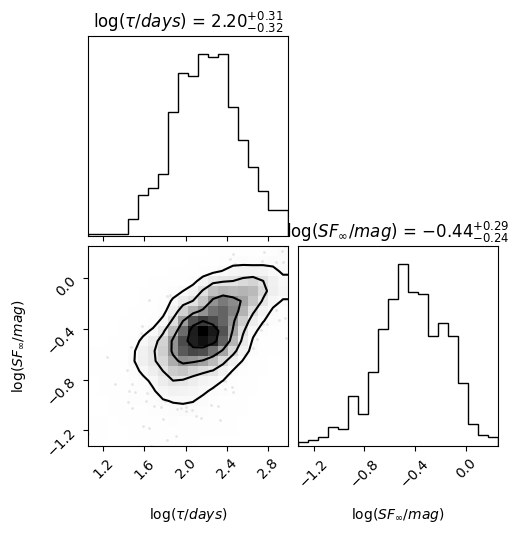

In [ ]:
# plot SF and Tau

data = np.vstack([np.log10(Taus), np.log10(SFs)]).T

labels = [r"$\log (\tau/days)$", r"$\log (SF_{\infty}/mag)$"]

fig = corner.corner(
    data, labels=labels, show_titles=True, plot_datapoints=True, smooth=1.0
)

plt.show()